In [3]:
import gym
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from skopt.optimizer import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
np.random.seed(0)

In [4]:
env = gym.make('FrozenLake-v0')

In [5]:
?env.env

Type:        FrozenLakeEnv
String form: <FrozenLakeEnv<FrozenLake-v0>>
File:        c:\users\taha\anaconda3\lib\site-packages\gym\envs\toy_text\frozen_lake.py
Docstring:  
Winter is here. You and your friends were tossing around a frisbee at the
park when you made a wild throw that left the frisbee out in the middle of
the lake. The water is mostly frozen, but there are a few holes where the
ice has melted. If you step into one of those holes, you'll fall into the
freezing water. At this time, there's an international frisbee shortage, so
it's absolutely imperative that you navigate across the lake and retrieve
the disc. However, the ice is slippery, so you won't always move in the
direction you intend.
The surface is described using a grid like the following

    SFFF
    FHFH
    FFFH
    HFFG

S : starting point, safe
F : frozen surface, safe
H : hole, fall to your doom
G : goal, where the frisbee is located

The episode ends when you reach the goal or fall in a hole.
You receive a 

In [19]:
class QLearningAgent():
    
    def __init__(self, env, state_space, min_lr, min_epsilon, gamma):
        
        self.env = env
        self.state_space = state_space
        self.min_lr = min_lr
        self.min_epsilon = min_epsilon
        self.gamma = gamma
    
    def update_epsilon_greedy(self, episode):
        self.epsilon = max(self.min_epsilon, min(1, 1.0 - math.log10((episode  + 1) / 25)))
        
    def update_lr(self, episode):
        self.lr = max(self.min_lr, min(1, 1.0 - math.log10((episode  + 1) / 25)))
    
    def train_Q(self, episodes):
        tic = time.time()
        self.Q_table = np.zeros((self.state_space,) + (self.env.action_space.n,))
        self.reward_list = []  
        self.plot_rewards = []

        for i in range(1, episodes+1):
            episode_reward = 0
            self.update_epsilon_greedy(i)
            self.update_lr(i)
            current = self.env.reset()
            done = False
            while not done:

                if np.random.random() < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    action = np.argmax(self.Q_table[current])

                observation, reward, done, info = self.env.step(action) 
                next_state = observation
                
                self.Q_table[current][action] += self.lr*(reward + (self.gamma*np.max(self.Q_table[next_state])) - self.Q_table[current][action])
                
                current = next_state
                episode_reward += reward
            
            self.reward_list.append(episode_reward)
            if i >= 500:
                self.plot_rewards.append(np.mean(self.reward_list[-500:]))

            
        toc = time.time()
        print(f'Finished training state-action function in {toc-tic:.2f} seconds')
        print('===================================================================')
        print(self.Q_table)
        return f'Total rewards over {episodes} episodes: {np.sum(self.reward_list)} and {np.mean(self.reward_list):.2f} average rewards'
    
    def test_Q(self, episodes):
        rewards = []
        episode_reward = 0
        for i in range(1, episodes+1):
            current = env.reset()
            done = False
            while not done:
                action = np.argmax(self.Q_table[current])
                observation, reward, done, info = env.step(action)
                next_state = observation
                episode_reward += reward
                current = next_state
            rewards.append(episode_reward)
            episode_reward = 0
        return f'Total rewards over {episodes} episodes: {np.sum(rewards)} and reached the goal {100*(np.mean(rewards))}% of the time'
    
    def plot_rewards_per_episode(self):
        sns.set_style('darkgrid')
        f, ax = plt.subplots(2,1,figsize=(10,8))
        sns.lineplot(x=range(len(self.plot_rewards)), y=self.plot_rewards, ax=ax[0])
        ax[0].set_title('Rolling Average Over Last 500 Episodes', size=17.5)
        ax[0].set_ylabel('Rewards', size=15)
        
        sns.lineplot(x=range(len(self.plot_rewards[:10000])), y=self.plot_rewards[:10000], ax=ax[1])
        ax[1].set_title('Rolling Average Over Last 500 Episodes (First 10,000)', size=17.5)
        ax[1].set_ylabel('Rewards', size=15)
        ax[1].set_xlabel('Episodes', size=15)

In [75]:
search = []
search.append(Real(0.01, 0.2, name='min_epsilon'))
search.append(Real(0.1, 1, name='gamma'))
search.append(Real(0.01, 0.2, name='min_lr'))

In [76]:
@use_named_args(search)
def average_rewards(min_epsilon, gamma, min_lr):
    Q_table = np.zeros((16,) + (env.action_space.n,))
    reward_list = []
        
    for i in range(1, 10000+1):
        episode_reward = 0
            
        lr = max(min_lr, min(1.0, 1.0 - math.log10((i + 1) / 25)))
        epsilon = max(min_epsilon, min(1, 1.0 - math.log10((i  + 1) / 25)))
            
        current = env.reset()
        done = False
        while not done:
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q_table[current])
            
            observation, reward, done, info = env.step(action) 
            next_state = observation
                
            Q_table[current][action] += lr*(reward + (gamma*np.max(Q_table[next_state])) - Q_table[current][action])
                
            current = next_state
            episode_reward += reward
             

        reward_list.append(episode_reward)

    return 10000 - np.sum(reward_list)

In [79]:
result = gp_minimize(func=average_rewards, dimensions=search)

In [80]:
print(f'Highest Total Reward: {10000.0 - result.fun:.2f}')
print('--------------------------------------------')
print(pd.DataFrame(data=result.x, index=['Minimum Epsilon', 'Gamma', 'Minimum Learning Rate'], 
                   columns=['Best Hyperparameters']))

Highest Total Reward: 6616.00
--------------------------------------------
                       Best Hyperparameters
Minimum Epsilon                        0.01
Gamma                                  1.00
Minimum Learning Rate                  0.01


Due to the stochastic nature of the environment and epsilon-greedy the results will vary, but the optimizer will still output a well performing model

In [20]:
qlearn = QLearningAgent(env=gym.make('FrozenLake-v0'), state_space=16, min_lr=0.01, min_epsilon=0.01, gamma=1.0)

In [21]:
qlearn.train_Q(100000)

Finished training state-action function in 88.54 seconds
[[7.51496567e-01 6.31361035e-01 6.10728044e-01 6.14949358e-01]
 [3.98065066e-01 1.02948820e-01 7.65617615e-02 1.57924605e-01]
 [3.54692086e-01 8.73560353e-02 8.27559881e-02 9.71123713e-02]
 [4.79287442e-02 0.00000000e+00 1.38826296e-04 0.00000000e+00]
 [7.51952885e-01 5.09335550e-01 5.37854561e-01 5.06855323e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.57253155e-01 1.21050799e-01 2.15402924e-01 5.88023351e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.02017413e-01 5.16741431e-01 4.84772303e-01 7.52553271e-01]
 [5.61083954e-01 7.49895928e-01 4.50632927e-01 4.73154713e-01]
 [6.81591116e-01 5.26040199e-01 4.16310714e-01 3.55095692e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.03734078e-01 5.40445923e-01 8.36084312e-01 5.66010993e-01]
 [7.78326328e-01 9.15173829e-01 8.24166746e-01 8.20059842e-01

'Total rewards over 100000 episodes: 48423.0 and 0.48 average rewards'

In [22]:
qlearn.test_Q(10000)

'Total rewards over 10000 episodes: 7075.0 and reached the goal 70.75% of the time'

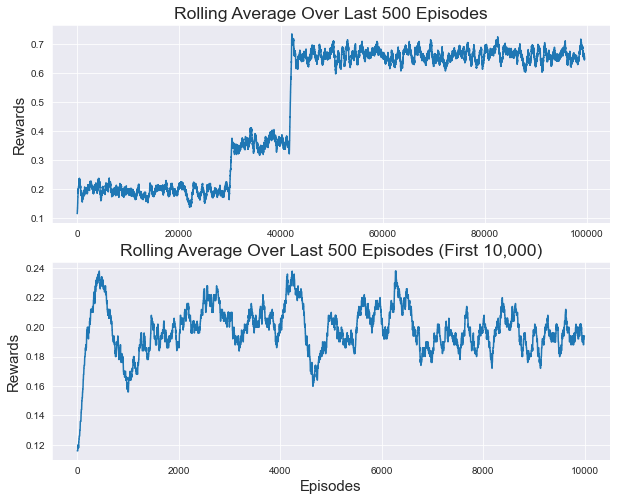

In [23]:
qlearn.plot_rewards_per_episode()